강화학습 실습(Grid World)
--

OpenAI의 Gym 설치 및 예제 돌려보기(가상환경 생성)

https://daeson.tistory.com/311

In [1]:
import gym

env = gym.make('CartPole-v0')

for i_episode in range(5):

    observation = env.reset()

    for t in range(10):

        env.render()

        print(observation)

        action = env.action_space.sample()

        observation, reward, done, info = env.step(action)

        if done:

            print("Episode finished after {} timesteps".format(t+1))

            break

[-0.04458659  0.03771081 -0.0086517  -0.01573852]
[-0.04383237  0.23295576 -0.00896647 -0.31113856]
[-0.03917325  0.4282043  -0.01518924 -0.6066357 ]
[-0.03060917  0.62353531 -0.02732195 -0.90406387]
[-0.01813846  0.42879385 -0.04540323 -0.62009236]
[-0.00956259  0.23433444 -0.05780508 -0.3420478 ]
[-0.0048759   0.0400805  -0.06464603 -0.0681388 ]
[-0.00407429  0.23606685 -0.06600881 -0.38049695]
[ 0.00064705  0.04194129 -0.07361875 -0.10933527]
[ 0.00148588  0.23803675 -0.07580545 -0.4243061 ]
[ 0.04844961 -0.04245224  0.03494639  0.02026218]
[ 0.04760057  0.15215157  0.03535164 -0.26119315]
[ 0.0506436   0.34675152  0.03012777 -0.54251947]
[ 0.05757863  0.54143738  0.01927738 -0.82555951]
[ 0.06840738  0.34605716  0.00276619 -0.52687644]
[ 0.07532852  0.15089639 -0.00777134 -0.23332315]
[ 0.07834645 -0.04411366 -0.0124378   0.05689835]
[ 0.07746417 -0.23905509 -0.01129983  0.34563125]
[ 0.07268307 -0.04377424 -0.00438721  0.04940659]
[ 0.07180759 -0.238833   -0.00339907  0.3407021 ]


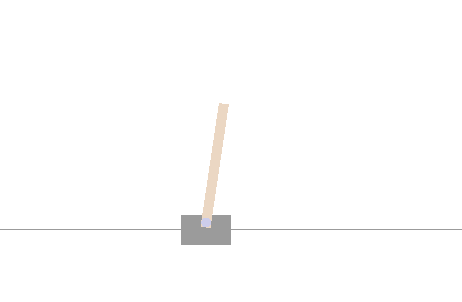

OpenAI 짐에서 그리드 월드 환경 구현
--

In [2]:
import numpy as np
from gym.envs.toy_text import discrete
from collections import defaultdict
import time
import pickle
import os
from gym.envs.classic_control import rendering

In [3]:
CELL_SIZE=100
MARGIN=10

def get_coords(row, col, loc='center'):
    xc=(col+1.5)*CELL_SIZE
    yc=(row+1.5)*CELL_SIZE
    if loc=='center':
        return xc, yc
    elif loc=='interior_corners':
        half_size=CELL_SIZE//2-MARGIN
        xl, xr=xc-half_size, xc+half_size
        yt, yb=xc-half_size, xc+half_size
        return [(xl, yt), (xr, yt), (xr, yb), (xl, yb)]
    elif loc=='interior_triangle':
        x1, y1=xc, yc + CELL_SIZE//3
        x2, y2=xc + CELL_SIZE//3, yc-CELL_SIZE//3
        x3, y3=xc-CELL_SIZE//3, yc-CELL_SIZE//3
        return [(x1,y1), (x2,y2),(x3,y3)]
    
def draw_object(coords_list):
    if len(coords_list) ==1: # -> 원
        obj=rendering.make_circle(int(0.45*CELL_SIZE))
        obj_transform=rendering.Transform()
        obj.add_attr(obj_transform)
        obj_transform.set_translation(*coords_list[0])
        obj.set_color(0.2, 0.2, 0.2) # -> 검정
    elif len(coords_list)==3: # -> 삼각형
        obj=rendering.FilledPolygon(coords_list)
        obj.set_color(0.9, 0.6, 0.2) # -> 노랑
    elif len(coords_list)>3: # -> 다각형
        obj=rendering.FilledPolygon(coords_list)
        obj.set_color(0.4,0.4,0.8) #-> 파랑
    return obj

- get_coords()는 기하학적 모양을 반환합니다.
- draw_object()는 전달된 좌표 리스트를 기반으로 원, 삼각형, 다각형을 그립니다.

In [4]:
class GridWorldEnv(discrete.DiscreteEnv):
    def __init__(self, num_rows=4, num_cols=6, delay=0.05):
        self.num_rows=num_rows
        self.num_cols=num_cols
        self.delay=delay
        move_up=lambda row, col: (max(row-1, 0), col)
        move_down=lambda row, col: (min(row+1, num_rows-1), col)
        move_left=lambda row, col: (row, max(col-1, 0))
        move_right=lambda row, col:(row, min(col+1, num_cols-1))
        # lambda 함수로 네 개의 행동을 정의합니다.
        self.action_defs={0: move_up, 1:move_right, 2:move_down, 3:move_left}
        
        #상태와 행동 개수
        nS=num_cols*num_rows
        nA=len(self.action_defs)
        self.grid2state_dict={(s//num_cols, s%num_cols):s for s in range(nS)}
        self.state2grid_dict={s:(s//num_cols, s%num_cols) for s in range(nS)}
        
        #골드 상태
        gold_cell=(num_rows//2, num_cols-2)
        
        #함정 상태
        trap_cells=[((gold_cell[0]+1), gold_cell[1]),
                   (gold_cell[0], gold_cell[1]-1),
                   ((gold_cell[0]-1), gold_cell[1])]
        gold_state=self.grid2state_dict[gold_cell]
        trap_states=[self.grid2state_dict[(r,c)] for (r,c) in trap_cells]
        self.terminal_states = [gold_state]+trap_states
        print(self.terminal_states)
        
        # 전이확률 만들기
        P=defaultdict(dict)
        # 전이확률은 어떤 행동이 선택되었을 때 한 상태에서 다른 상태로
        # 이동할 확률을 결정합니다. 이로 인해 우연에 의한 행동 선택이 
        # 다른 결과를 가져올 수 있는 확률적인 환경을 가지게 됩니다.
        for s in range(nS):
            row, col=self.state2grid_dict[s]
            P[s]=defaultdict(list)
            for a in range(nA):
                action=self.action_defs[a]
                next_s=self.grid2state_dict[action(row, col)]
                
                ## 종료 상태
                if self.is_terminal(next_s):
                    r=(1.0 if next_s == self.terminal_states[0] 
                       else -1.0)
                else:
                    r=0.0
                if self.is_terminal(s):
                    done=True
                    next_s=s
                else:
                    done=False
                P[s][a]=[(1.0, next_s, r, done)]
            
            ## 초기 상태 배치
            isd=np.zeros(nS)
            isd[0]=1.0
            # 넘파이 배열 isd는 시작 상태의 확률을 담고 있어
            # (부모 클래스의) reset() 메서드가 호출 될 때, 
            # 이 분포를 기반으로 랜덤한 상태가 선택됩니다.
            # (그리드 월드의 왼쪽 아래 모서리) 항상 상태 0에서 
            # 시작하기 때문에 상태 0의 확률을 1.0으로 지정합니다. 나머지 29개의
            # 상태 확률은 0.0 입니다.
            super(GridWorldEnv, self).__init__(nS, nA, P, isd)
            self.viewer=None
            self._build_display(gold_cell, trap_cells)
            
    def is_terminal(self, state):
        return state in self.terminal_states
    
    def _build_display(self, gold_cell, trap_cells):
        # 환경의 기본 모습 시각화
        screen_width=(self.num_cols+2)*CELL_SIZE
        screen_height=(self.num_rows+2)*CELL_SIZE
        self.viewer=rendering.Viewer(screen_width, screen_height)
        
        all_objects=[]
        
        ## 경계 위치 좌표
        bp_list=[
            (CELL_SIZE-MARGIN, CELL_SIZE-MARGIN),
            (screen_width-CELL_SIZE+MARGIN, CELL_SIZE-MARGIN),
            (screen_width-CELL_SIZE+MARGIN,
            screen_height-CELL_SIZE+MARGIN),
            (CELL_SIZE-MARGIN, screen_height-CELL_SIZE+MARGIN)
        ]
        border=rendering.PolyLine(bp_list, True)
        border.set_linewidth(5)
        all_objects.append(border)
        ## 수직선
        for col in range(self.num_cols+1):
            x1, y1=(col+1)*CELL_SIZE, CELL_SIZE
            x2, y2=(col+1)*CELL_SIZE, \
            (self.num_rows+1)*CELL_SIZE
            line=rendering.PolyLine([(x1,y1),(x2,y2)], False)
            all_objects.append(line)
            
        ## 수평선
        for row in range(self.num_rows+1):
            x1, y1=CELL_SIZE, (row+1)*CELL_SIZE
            x2, y2=(self.num_cols+1)*CELL_SIZE, \
            (row+1)*CELL_SIZE
            line=rendering.PolyLine([(x1,y1),(x2,y2)], False)
            all_objects.append(line)
            
        ## 함정: -> 원
        for cell in trap_cells:
            trap_coords = get_coords(*cell, loc='center')
            all_objects.append(draw_object([trap_coords]))
            
        ## 골드: -> 삼각형
        gold_coords=get_coords(*gold_cell, loc='interior_triangle')
        all_objects.append(draw_object(gold_coords))
        
        ## 에이전트 --> 사각형 또는 로봇
        if (os.path.exists('robot-coordinates.pkl') and CELL_SIZE==100):
            agent_coords=pickle.load(open('robot=coordinates.pkl', 'rb'))
            starting_coords=get_coords(0,0,loc="center")
            agent_coords+=np.array(starting_coords)
        else:
            agent_coords=get_coords(0,0, loc='interior_corners')
        
        agent=draw_object(agent_coords)
        self.agent_trans=rendering.Transform()
        agent.add_attr(self.agent_trans)
        all_objects.append(agent)
        for obj in all_objects:
            self.viewer.add_geom(obj)
            
    def render(self, mode='human', done=False):
        # 에이전트의 이동을 보여줌.
        if done:
            sleep_time=1
        else:
            sleep_time= self.delay
        x_coord=self.s%self.num_cols
        y_coord=self.s//self.num_cols
        x_coord=(x_coord+0)*CELL_SIZE
        y_coord=(y_coord+0)*CELL_SIZE
        self.agent_trans.set_translation(x_coord, y_coord)
        rend=self.viewer.render(
            return_rgb_array=(mode=='rgb_array'))
        time.sleep(sleep_time)
        return rend
    
    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer=None        

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
if __name__=='__main__':
    env=GridWorldEnv(5,6)
    for i in range(1):
        s=env.reset()
        env.render(mode='human', done=False)
        while True:
            action=np.random.choice(env, nA)
            res=env.step(action)
            print("행동", env.s, action, '->', res)
            env.render(mode='human', done=res[2])
            if res[2]:
                break
    env.close()

[16, 22, 15, 10]


Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x00000200A15E19E8>>
Traceback (most recent call last):
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\bella\anaconda3\envs\gym\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x000002009E4A3D68; to 'Win32Window' at 0x00000200A15CA4E0>,)
Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic

Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x00000200ABA3DBE0>>
Traceback (most recent call last):
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\bella\anaconda3\envs\gym\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x00000200A15FFAE8; to 'Win32Window' at 0x00000200A88A0D68>,)
Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic

Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x00000200B4DB8828>>
Traceback (most recent call last):
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\bella\anaconda3\envs\gym\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x00000200ABA5EF98; to 'Win32Window' at 0x00000200A15CAB00>,)
Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic

    self.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\bella\anaconda3\envs\gym\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x000002009E3CC908; to 'Win32Window' at 0x00000200B4DB8BA8>,)


Q-러닝으로 그리드 월드 문제 풀기
--

agent.py 스크립트는 환경과 상호작용할 에이전트를 정의합니다.

In [6]:
# agent.py 스크립트는 환경과 상호작용할 에이전트를 정의합니다.

from collections import defaultdict
import numpy as np

class Agent(object):
    def __init__(
            self, env,
            learning_rate=0.01,
            discount_factor=0.9,
            epsilon_greedy=0.9,
            epsilon_min=0.1,
            epsilon_decay=0.95):
        self.env=env
        self.lr=learning_rate
        self.gamma=discount_factor
        self.epsilon=epsilon_greedy
        self.epsion_min=epsilon_min
        self.epsilon_decay=epsilon_decay
        
        # q_table 정의
        self.q_table=defaultdict(lambda: np.zeros(self.env.nA))

    def choose_action(self, state):
        # epsilon-그리드 정책을 기반으로 행동을 선택함.
        # 랜덤한 균등 분포를 사용하여 랜덤한 행동을 선택할지
        # 아니면 행동-가치 함수를 기반으로 선택할지 결정함.
        if np.random.uniform() < self.epsilon:
            action=np.random.choice(self.env.nA)
        else:
            q_vals=self.q_table[state]
            perm_actions=np.random.permutation(self.env.nA)
            q_vals=[q_vals[a] for a in perm_actions]
            perm_q_argmax=np.argmax(q_vals)
            action=perm_actions[perm_q_argmax]
        return action
    
    def _learn(self, transition):
        # Q-러닝 알고리즘의 업데이트 규칙을 구현합니다.
        s,a,r,next_s, done=transition
        q_val=self.q_table[s][a]
        if done:
            q_target=r
        else:
            q_target=r+self.gamma*np.max(self.q_table[next_s])
            
        ## q_table 업데이트
        self.q_table[s][a] += self.lr*(q_target-q_val)
        ## epsilon 조정
        self._adjust_epsilon()
        # 초기에 높은 epsilon으로 시작하지만, _adjust_epsilon() 메서드가 최솟값에 도달 할 때까지 감소시킴.
        
    def _adjust_epsilon(self):
        if self.epsilon>self.epsilon_min:
            self.epsilon *= self.epsilon_decay

qlearning.py

In [16]:
import matplotlib.pyplot as plt

In [18]:
from collections import namedtuple

In [20]:
np.random.seed(1)
Transition=namedtuple(
'Transition', ('state','action','reward','next_state','done'))

def run_qlearning(agent, env, num_episodes=50):
    history=[]
    for episode in range(num_episodes):
        state=env.reset()
        env.render(mode='human')
        final_reward, n_moves=0.0, 0
        while True:
            action=agent.choose_action(state)
            next_s, reward, done, _ = env.step(action)
            agent._learn(Transtition(state, action, reward, next_s, done))
            env.render(mode='human', done=done)
            state=next_s
            n_moves += 1
            if done:
                break
            final_reward=reward
        history.append((n_moves, final_reward))
        print("에피소드 %d: 보상 %.1f #이동 %d"%(episode, final_reward, n_moves))
        return history

def plot_learning_history(history):
    fig=plt.figure(1, figsize=(14, 10))
    ax=fig.add_subplot(2,1,1)
    episodes=np.arange(len(history))
    moves=np.array([h[0] for h in history])
    plt.plot(episodes, moves, lw=4, marker='o', markersize=10)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Episodes', size=20)
    plt.ylabel('# moves', size=20)
    ax=fig.add_subplot(2,1,2)
    rewards=np.array([h[1] for h in history])
    plt.step(episodes, rewards, lw=4)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Episodes', size=20)
    plt.ylabel('Final rewards', size=20)
    plt.savefig('q-learning-history.png', dpi=300)
    plt.show()

In [ ]:
if __name__ == '__main__':
    env=GridWorldEnv(num_rows=5, num_cols=6)
    agent=Agent(env)
    history=run_qlearning(agent, env)
    env.close()
    plot_learning_history(history)

[16, 22, 15, 10]


Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x000001B1345A3CC0>>
Traceback (most recent call last):
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\bella\anaconda3\envs\gym\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x000001B12915F688; to 'Win32Window' at 0x000001B1345A3F60>,)
Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic

Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x000001B0E19794A8>>
Traceback (most recent call last):
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\bella\anaconda3\envs\gym\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x000001B0E1DA5098; to 'Win32Window' at 0x000001B0E0519CC0>,)
Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic

    self.window.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\bella\anaconda3\envs\gym\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x000001B129147A48; to 'Win32Window' at 0x000001B12915CB70>,)
Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x000001B12C2F0390>>
Traceback (most recent call last):
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\s

KeyError: (<weakref at 0x000001B12912E7C8; to 'Win32Window' at 0x000001B12C2F0550>,)
Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x000001B12C2F06D8>>
Traceback (most recent call last):
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\bella\anaconda3\envs\gym\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\bella\anaconda3\envs\gym\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x000001B1291478B8; to 'Win32Window' at 0x000001

KeyboardInterrupt: 